In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc
import time


from IPython.display import clear_output

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data



In [7]:
def double_ma_long(df_cp, Wx=None, Wy=None, coeff=1):
    # Wx < Wy
    df = df_cp.copy()
    df[f'close_ma_Wx'] = df[f'close'].rolling(window=Wx, min_periods=Wx).mean().values
    df[f'close_ma_Wy'] = df[f'close'].rolling(window=Wy, min_periods=Wy).mean().values

    # #mask_Wy
    # mask_Wy = df[f'close_ma_Wy'].notnull()
    # df = df[mask_Wy].reset_index(drop=True)

    inds_long = np.argwhere(df[f'close_ma_Wx'] > df[f'close_ma_Wy']).ravel()
    # if inds_long.shape[0] == 0:
    #     return pd.DataFrame()

    
    #эту штуку нужно дорабатывать до кейса с одним пробегом, либо засовывать в функцию большие промежутки данных
    i_start = 0
    if inds_long[0] == 0:
        i_start = 1
        while inds_long[i_start] - inds_long[i_start-1] == 1:
            i_start += 1   
            
    i_end = inds_long.shape[0]
    if inds_long[-1] == df.shape[0] - 1:
        i_end = -1
        while inds_long[i_end] - inds_long[i_end-1] == 1:
            i_end -= 1
            
    inds_long = inds_long[i_start:i_end]

    #indexes in inds_long
    inds_run_start = np.argwhere(inds_long[1:] - inds_long[:-1] != 1).ravel() + 1
    inds_run_end = inds_run_start - 1
    #indexes in inds_long
    inds_run_start = np.array([0] + inds_run_start.tolist())
    inds_run_end = np.array(inds_run_end.tolist() + [inds_long.shape[-1] - 1])
    #indexes in df
    inds_run_start = inds_long[inds_run_start]
    inds_run_end = inds_long[inds_run_end] + 1
    #return inds_run_start, inds_run_end
    
    #income_rate
    start_price = df.loc[inds_run_start, 'close'].values
    res_price = df.loc[inds_run_end, 'close'].values
    if Wx < Wy: #long game
        income_rate = res_price/start_price
    else: #short game
        income_rate = (2*start_price-res_price)/start_price
    
    df_res = pd.DataFrame({'ind_start' : inds_run_start,
                          'ind_end' : inds_run_end,
                          'time_start' : df.loc[inds_run_start, 'time'].values,
                          'time_end' : df.loc[inds_run_end, 'time'].values,
                          'delta_time' : df.loc[inds_run_end, 'time'].values - df.loc[inds_run_start, 'time'].values,
                          'price_start' : start_price,
                          'price_end' : res_price,
                          'income_rate' : income_rate
                          })

            
    return df_res



def multiply(arr):
    res = 1
    for elem in arr:
        res *= elem
    return res

def sum_income_fix_bid(arr):
    return np.sum(arr - 1)

### 1. ALL

In [26]:
tickers = ['TON-USDT',
          'NEAR-USDT',
         'BTC-USDT',
         'ETH-USDT',
         'ETC-USDT',
         'XRP-USDT',
         'BNB-USDT',
         'SOL-USDT',
         'DOGE-USDT',
         'ADA-USDT',
         'TRX-USDT',
         'LINK-USDT', 
         'AVAX-USDT', 
         'SUI-USDT',
         'XLM-USDT',
         'LTC-USDT',
         
         'SHIB-USDT',
         'HBAR-USDT',
         'DOT-USDT',
         'BCH-USDT',
         'OP-USDT', 
         
         'AAVE-USDT',
         'LDO-USDT',
         'ARB-USDT',
         'UNI-USDT',
         'ATOM-USDT', #26
         ]

Wxs = [30,  60,  90, 120]

res_tickers = []
res_Wx = []
res_Wy = []
res_strategy = []
res_mean_ir_2024_3 = []
res_sum_ir_2024_3 = []
res_mean_ir_2024_4 = []
res_sum_ir_2024_4 = []
res_mean_ir_2025 = []
res_sum_ir_2025 = []
count_2025 = []
count_2024_3 = []
count_2024_4 = []

#long

for ticker in tqdm(tickers):
    for Wx in Wxs:
        for Wy in Wxs:
            if Wx != Wy:
                df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')
    
                df_res = double_ma_long(df, Wx=Wx, Wy=Wy)

                res_tickers += [ticker]
                res_Wx += [Wx]
                res_Wy += [Wy]
                res_strategy += ['long' if Wx < Wy else 'short']
    
                mask_2025 = df_res['time_start'] > pd.Timestamp('2025-01-01')   
                count_2025 += [mask_2025.sum()]
                res_mean_ir_2025 += [df_res.loc[mask_2025, 'income_rate'].mean() - 1]
                res_sum_ir_2025 += [sum_income_fix_bid(df_res.loc[mask_2025, 'income_rate'])]

                mask_2024_3 = (df_res['time_start'] > pd.Timestamp('2024-07-01')) & (pd.Timestamp('2024-10-01') > df_res['time_start'])
                count_2024_3 += [mask_2024_3.sum()]
                res_mean_ir_2024_3 += [df_res.loc[mask_2024_3, 'income_rate'].mean() - 1]
                res_sum_ir_2024_3 += [sum_income_fix_bid(df_res.loc[mask_2024_3, 'income_rate'])]

                mask_2024_4 = (df_res['time_start'] > pd.Timestamp('2024-10-01')) & (pd.Timestamp('2025-01-01') > df_res['time_start'])
                count_2024_4 += [mask_2024_4.sum()]
                res_mean_ir_2024_4 += [df_res.loc[mask_2024_4, 'income_rate'].mean() - 1]
                res_sum_ir_2024_4 += [sum_income_fix_bid(df_res.loc[mask_2024_4, 'income_rate'])]
            
df_result = pd.DataFrame({'ticker' : res_tickers,
                          'strat' : res_strategy,
                          'Wx' : res_Wx,
                          'Wy' : res_Wy,

                          'c_2024_3' : count_2024_3,
                          'c_2024_4' : count_2024_4,
                          'c_2025' : count_2025,
                          
                          'm_ir_2024_3' : res_mean_ir_2024_3,
                          'm_ir_2024_4' : res_mean_ir_2024_4,
                          'm_ir_2025' : res_mean_ir_2025,
                          
                          's_ir_2024_3' : res_sum_ir_2024_3,
                          's_ir_2024_4' : res_sum_ir_2024_4,
                          's_ir_2025' : res_sum_ir_2025,
                         })

100%|█████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 47.82it/s]


In [28]:
df_result.shape

(312, 13)

In [38]:
threshold = 0.1
mask = (df_result['s_ir_2024_3'] > threshold) & (df_result['s_ir_2024_4'] > threshold) & (df_result['s_ir_2025'] > threshold)

pd.set_option('display.max_rows', 200)
df_result[mask].sort_values(by=['ticker', 'Wx'], ascending=False)

ticker  strat   Wx   Wy  c_2024_3  c_2024_4  c_2025  m_ir_2024_3  \
68    XRP-USDT   long   90  120        14        10      13     0.007496   
60    XRP-USDT   long   30   60        21        21      20     0.014514   
61    XRP-USDT   long   30   90        17        13      16     0.023271   
62    XRP-USDT   long   30  120        11        11      13     0.016920   
219   DOT-USDT  short   60   30        15        16      21     0.032588   
147  AVAX-USDT  short   60   30        19        20      17     0.016730   
286   ARB-USDT  short  120   60         8        10       9     0.020874   
111   ADA-USDT  short   60   30        19        19      18     0.010160   

     m_ir_2024_4  m_ir_2025  s_ir_2024_3  s_ir_2024_4  s_ir_2025  
68      0.197669   0.007903     0.104939     1.976689   0.102742  
60      0.072888   0.018506     0.304801     1.530646   0.370124  
61      0.119247   0.017313     0.395608     1.550205   0.277005  
62      0.147723   0.024140     0.186117     1.624958   0.313814  
219     0.010155   0.005480     0.488823     0.162480   0.115071  
147     0.005576   0.017363     0.317868     0.111527   0.295168  
286     0.012091   0.014014     0.166993     0.120913   0.126126  
111     0.005722   0.005613     0.193040     0.108721   0.101040

In [ ]:
# 61 	XRP-USDT 	long 	30 	90
# 286 	ARB-USDT 	short 	120 	60

In [40]:
# 61 	XRP-USDT 	long 	30 	90

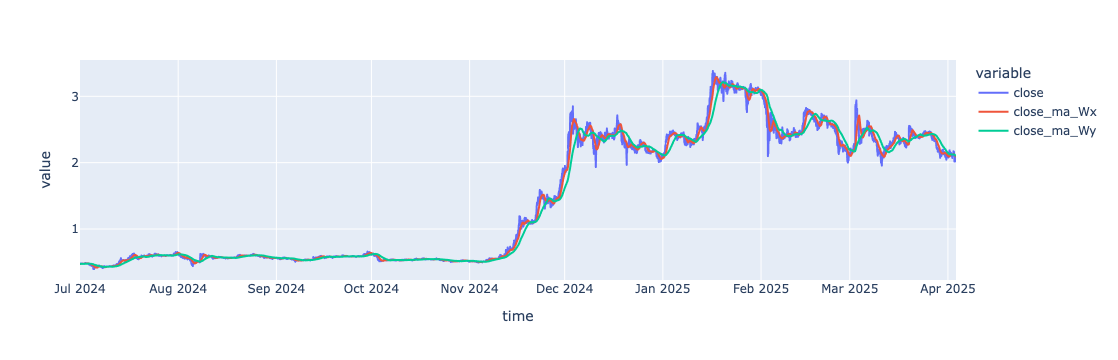

In [25]:
import plotly.express as px

ticker = "XRP-USDT"
df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')

window = 30
df[f'close_ma_Wx'] = df[f'close'].rolling(window=window, min_periods=window).mean().values

window = 90
df[f'close_ma_Wy'] = df[f'close'].rolling(window=window, min_periods=window).mean().values

mask = df['time'] >= pd.Timestamp('2024-07-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx', f'close_ma_Wy']].set_index('time'))

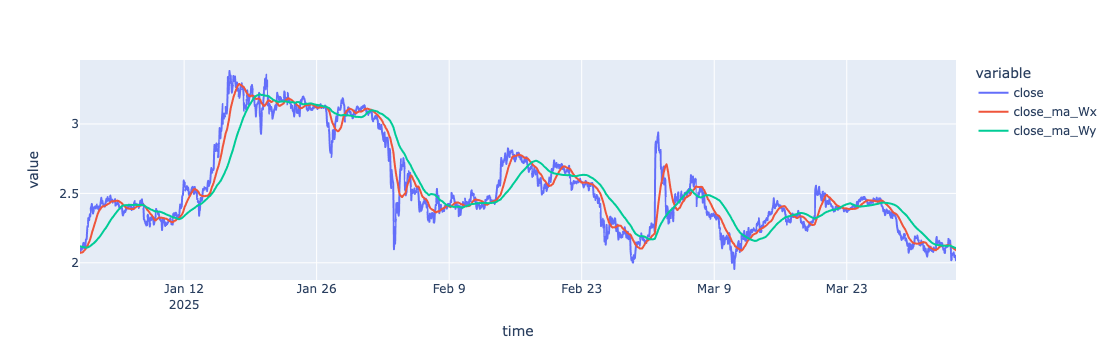

In [27]:
mask = df['time'] >= pd.Timestamp('2025-01-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx', f'close_ma_Wy']].set_index('time'))

In [13]:
#Статистика: 2 апреля -,


In [15]:
df

time   close        volume    ticker  close_ma_Wx  \
0     2024-01-01 00:00:00  0.6193  8.903832e+05  XRP-USDT          NaN   
1     2024-01-01 01:00:00  0.6114  4.429614e+06  XRP-USDT          NaN   
2     2024-01-01 02:00:00  0.6154  1.946286e+06  XRP-USDT          NaN   
3     2024-01-01 03:00:00  0.6161  1.991544e+06  XRP-USDT          NaN   
4     2024-01-01 04:00:00  0.6183  1.582030e+06  XRP-USDT          NaN   
...                   ...     ...           ...       ...          ...   
10975 2025-04-02 07:00:00  2.1007  5.674372e+05  XRP-USDT     2.124867   
10976 2025-04-02 08:00:00  2.0727  1.673414e+06  XRP-USDT     2.124287   
10977 2025-04-02 09:00:00  2.0707  1.061646e+06  XRP-USDT     2.124050   
10978 2025-04-02 10:00:00  2.1090  1.617668e+06  XRP-USDT     2.124900   
10979 2025-04-02 11:00:00  2.1058  2.052324e+06  XRP-USDT     2.124753   

       close_ma_Wy  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
10975     2.122961  
10976     2.122792  
10977     2.122423  
10978     2.122094  
10979     2.121969  

[10980 rows x 6 columns]

In [34]:
# 286 	ARB-USDT 	short 	120 	60

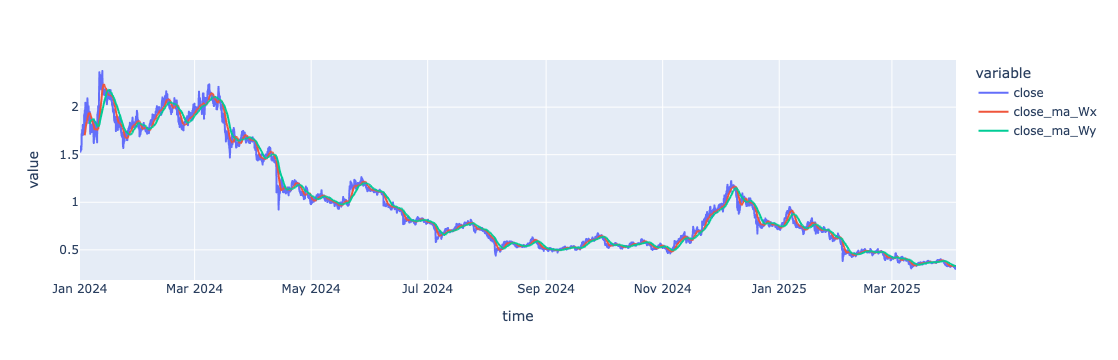

In [29]:
import plotly.express as px

ticker = "ARB-USDT"
df = load_pkl(f'./data/raw/1hour/{ticker}.pkl')

window = 60
df[f'close_ma_Wx'] = df[f'close'].rolling(window=window, min_periods=window).mean().values

window = 120
df[f'close_ma_Wy'] = df[f'close'].rolling(window=window, min_periods=window).mean().values

mask = df['time'] >= pd.Timestamp('2024-01-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx', f'close_ma_Wy']].set_index('time'))

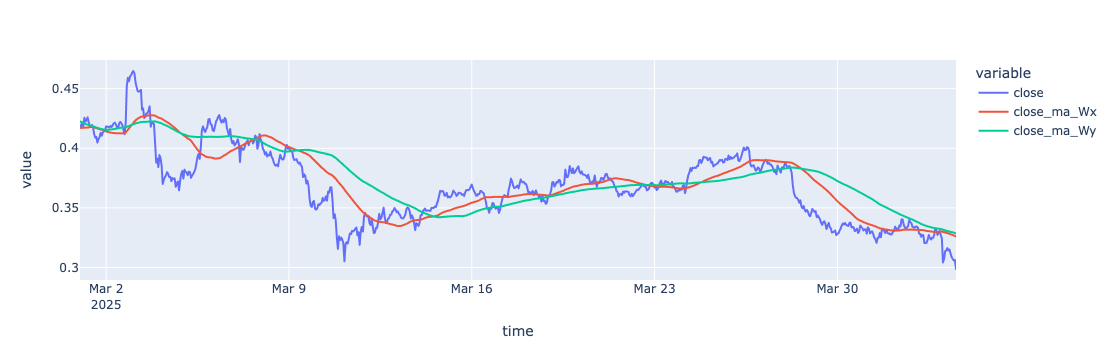

In [31]:
mask = df['time'] >= pd.Timestamp('2025-03-01')
px.line(df.loc[mask, ['time', f'close', f'close_ma_Wx', f'close_ma_Wy']].set_index('time'))